# ***Análise Exploratória*** - Desafio Participa DF

**Objetivo:** Explorar o conjunto de dados de solicitações de acesso à informação e desenvolver uma solução para identificar automaticamente textos que contenham dados pessoais.

**Categoria:** Acesso à Informação

**Autor:** Lucas  Boros

**Data:** Janeiro/2026

## `Importação das Bibliotecas Utilizadas no Projeto`

In [1]:
# Manipulação de dados
import pandas as pd
import numpy as np

# Visualização
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Configurações gerais
import warnings
warnings.filterwarnings('ignore')

# Configuração de visualização
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

## `Carregamentos dos Dados`

In [2]:
# Carregar o dataset
df = pd.read_excel('AMOSTRA_e-SIC.xlsx')

# Visualização inicial
print(f"Shape do dataset: {df.shape}")
df.head()

Shape do dataset: (99, 2)


,ID,Texto Mascarado
0,1,Solicito cópia do cadastro que preenchi virtua...
1,2,Gostaria de saber da defensoria se q irão impl...
2,3,Oi estou chateada o meu companheiro está estra...
3,4,"Prezados senhores, boa tarde!\n\nSolicito aces..."
4,5,Solicito acesso a um laudo de adicional de per...


>  `Informações sobre o Dataset`

- **99 registros/linhas** (solicitações de acesso à informação)
- **2 atributos/colunas:** ID e Texto Mascarado


## `Análise Exploratória do Conjunto de Dados`

In [3]:
# Informações gerais do dataset
print("=== INFORMAÇÕES DO DATASET ===")
df.info()

=== INFORMAÇÕES DO DATASET ===
<class 'pandas.DataFrame'>
RangeIndex: 99 entries, 0 to 98
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   ID               99 non-null     int64
 1   Texto Mascarado  99 non-null     str  
dtypes: int64(1), str(1)
memory usage: 1.7 KB


In [4]:
# Estatísticas descritivas
print("=== ESTATÍSTICAS DESCRITIVAS ===")
df.describe()

=== ESTATÍSTICAS DESCRITIVAS ===


,ID
count,99.000000
mean,50.000000
std,28.722813
min,1.000000
25%,25.500000
50%,50.000000
75%,74.500000
max,99.000000


In [5]:
# Verificar valores nulos
print("=== VALORES NULOS ===")
print(df.isnull().sum())

# Verificar duplicatas
print(f"\nDuplicatas: {df.duplicated().sum()}")

=== VALORES NULOS ===
ID                 0
Texto Mascarado    0
dtype: int64

Duplicatas: 0


### => ***Análise Exploratória do Texto:***

In [6]:
# Visualizar primeiros exemplos de texto
print("=== EXEMPLOS DE SOLICITAÇÕES ===")
for i in range(5):
    print(f"\n--- ID {df['ID'].iloc[i]} ---")
    print(df['Texto Mascarado'].iloc[i][:300], "...")  # Primeiros 300 caracteres

=== EXEMPLOS DE SOLICITAÇÕES ===

--- ID 1 ---
Solicito cópia do cadastro que preenchi virtualmente solicitando, em maio deste ano, a transferência de titularidade da conte de água da casa da casa para qual me mudei, para ter acesso a leitura que informei do consumo registrado no hidrômetro, a fim de conferir se a fatura que estão me cobrando es ...

--- ID 2 ---
Gostaria de saber da defensoria se q irão implementar o reajuste no auxílio saúde, pois houve uma mudança na faixa de valores da minha dependente, pois ela mudou de idade. No entanto, não percebi ainda nenhum reajuste no repasse,  mesmo a mensalidade aumentando. ...

--- ID 3 ---
Oi estou chateada o meu companheiro está estranho por e-mail passando a empresa ele este queimado ele, na verdade, a consciência de se  cuidar, de sua saúde emocional informado de direitos e deveres, de seu pé, seu cróxis e pé e cuidado de seus filhos pais e respeita ex casa ele promove destruição p ...

--- ID 4 ---
Prezados senhores, boa tarde!

Sol

In [7]:
# Estatísticas básicas do texto
df['tamanho_texto'] = df['Texto Mascarado'].apply(len)
df['qtd_palavras'] = df['Texto Mascarado'].apply(lambda x: len(x.split()))

print("=== ESTATÍSTICAS DO TEXTO ===")
print(f"Tamanho médio (caracteres): {df['tamanho_texto'].mean():.0f}")
print(f"Quantidade média de palavras: {df['qtd_palavras'].mean():.0f}")
print(f"Menor texto: {df['tamanho_texto'].min()} caracteres")
print(f"Maior texto: {df['tamanho_texto'].max()} caracteres")

=== ESTATÍSTICAS DO TEXTO ===
Tamanho médio (caracteres): 507
Quantidade média de palavras: 77
Menor texto: 10 caracteres
Maior texto: 3229 caracteres


### => ***Busca Exploratória por padrões de dados pessoais***

Utilizei **expressões regulares (regex)** para identificar padrões estruturados de dados pessoais como CPF, e-mail, telefone, etc.

In [8]:
import re

# Padrões corrigidos e mais específicos
padroes = {
    'CPF': r'\d{3}\.\d{3}\.\d{3}-\d{1,2}|\d{11}',
    'E-mail': r'[a-zA-Z0-9._%+-]+@[a-zA-Z0-9.-]+\.[a-zA-Z]{2,}',
    'Telefone': r'\(\d{2}\)\s?\d{4,5}-\d{4}|\d{2}\s\d{4,5}-?\d{4}',
    'Processo_SEI': r'\d{4,5}-\d{5,11}/\d{4}-\d{2}',
    'Matricula': r'[Mm]atr[ií]cula[:\s]+[\d.-]+|\d{2}\.\d{3}-\d{1}',
    'OAB': r'OAB[/-]?\w{2}[\s-]?\d{2,6}',
    'CNPJ': r'\d{2}\.\d{3}\.\d{3}/\d{4}-\d{2}'
}

# Verificar ocorrências de cada padrão
print("=== OCORRÊNCIAS DE PADRÕES ===\n")
for nome, padrao in padroes.items():
    encontrados = df['Texto Mascarado'].apply(lambda x: bool(re.search(padrao, str(x))))
    qtd = encontrados.sum()
    print(f"{nome}: {qtd} textos ({qtd/len(df)*100:.1f}%)")

=== OCORRÊNCIAS DE PADRÕES ===

CPF: 17 textos (17.2%)
E-mail: 7 textos (7.1%)
Telefone: 5 textos (5.1%)
Processo_SEI: 25 textos (25.3%)
Matricula: 12 textos (12.1%)
OAB: 3 textos (3.0%)
CNPJ: 4 textos (4.0%)


## **Versão 1** --  `Criação da Variável Target` 

Primeira abordagem: classificar textos usando apenas padrões regex.

In [9]:
# Função para detectar dados pessoais (v1 - apenas regex)
def contem_dados_pessoais(texto):
    texto = str(texto)
    
    padroes_dados_pessoais = {
        'CPF': r'\d{3}\.\d{3}\.\d{3}-\d{1,2}|\d{11}',
        'E-mail': r'[a-zA-Z0-9._%+-]+@[a-zA-Z0-9.-]+\.[a-zA-Z]{2,}',
        'Telefone': r'\(\d{2}\)\s?\d{4,5}-\d{4}|\d{2}\s\d{4,5}-?\d{4}',
        'Matricula': r'[Mm]atr[ií]cula[:\s]+[\d.-]+|\d{2}\.\d{3}-\d{1}',
        'OAB': r'OAB[/-]?\w{2}[\s-]?\d{2,6}',
        'CNPJ': r'\d{2}\.\d{3}\.\d{3}/\d{4}-\d{2}'
    }
    
    for nome, padrao in padroes_dados_pessoais.items():
        if re.search(padrao, texto):
            return 1  # Não Público (contém dados pessoais)
    
    return 0  # Público (não contém dados pessoais)

# Aplicar função
df['contem_dados_pessoais'] = df['Texto Mascarado'].apply(contem_dados_pessoais)

# Verificar distribuição
print("=== DISTRIBUIÇÃO DO TARGET (V1 - REGEX) ===")
print(df['contem_dados_pessoais'].value_counts())
print("\nProporção:")
print(df['contem_dados_pessoais'].value_counts(normalize=True))

=== DISTRIBUIÇÃO DO TARGET (V1 - REGEX) ===
contem_dados_pessoais
0    73
1    26
Name: count, dtype: int64

Proporção:
contem_dados_pessoais
0    0.737374
1    0.262626
Name: proportion, dtype: float64


## `Adicionando Detecção de Nomes com NLP (spaCy)`


O regex não captura **nomes de pessoas** por utilizei a biblioteca ***spaCy*** para detectar entidades do tipo PER (pessoa).

In [10]:
import spacy

# Carregar modelo em português
nlp = spacy.load('pt_core_news_sm')

# Teste rápido
doc = nlp("Meu nome é Ruth Helena Franco e meu CPF é 123.456.789-00")
print("=== TESTE DE DETECÇÃO DE ENTIDADES ===")
for ent in doc.ents:
    print(f"'{ent.text}' -> {ent.label_}")

=== TESTE DE DETECÇÃO DE ENTIDADES ===
'Ruth Helena Franco' -> PER
'CPF' -> MISC


In [11]:
# Testar em exemplos reais do dataset
print("=== TESTE DE DETECÇÃO DE NOMES NO DATASET ===\n")

ids_teste = [7, 10, 17, 19]

for id_teste in ids_teste:
    texto = df[df['ID'] == id_teste]['Texto Mascarado'].values[0]
    doc = nlp(texto)
    nomes = [ent.text for ent in doc.ents if ent.label_ == 'PER']
    print(f"ID {id_teste}: {nomes}")
    print()

=== TESTE DE DETECÇÃO DE NOMES NO DATASET ===

ID 7: ['Caesb', 'Júlio Cesar Alves da Rosa', 'Maria Martins Mota Silva', 'Caesb']

ID 10: ['Encaminho', 'Certidão', 'Ônus', 'Ruth Helena Franco CPF', 'Ruth']

ID 17: ['Jorge Luiz Pereira Vieira', 'Vossa Senhoria', 'Jorge Luiz Pereira Vieira']

ID 19: ['Walter Rodrigues Cruz', 'Sociedade de Transportes Coletivos de Brasília', 'Sr. Antonio Vasconcelos']



## **Versão 2** -- `Refinando a Detecção de Nomes` 

In [12]:
# Lista de falsos positivos comuns para filtrar
falsos_positivos = [
    'caesb', 'detran', 'tcb', 'der', 'seduh', 'seec', 'pmdf', 'cbmdf', 
    'vossa senhoria', 'vossas senhorias', 'excelência', 'encaminho',
    'certidão', 'ônus', 'atenciosamente', 'cordialmente', 'prezados',
    'prezado', 'prezada', 'ilustríssimo', 'sicoob', 'terracap', 'adasa'
]

def detectar_nomes_pessoas(texto):
    doc = nlp(str(texto))
    nomes = []
    for ent in doc.ents:
        if ent.label_ == 'PER':
            nome_lower = ent.text.lower().strip()
            if nome_lower not in falsos_positivos and len(ent.text.split()) >= 2:
                nomes.append(ent.text)
    return nomes

# Função completa de detecção de dados pessoais (v2)
def contem_dados_pessoais_v2(texto):
    texto = str(texto)
    
    padroes = {
        'CPF': r'\d{3}\.\d{3}\.\d{3}-\d{1,2}|\d{11}',
        'E-mail': r'[a-zA-Z0-9._%+-]+@[a-zA-Z0-9.-]+\.[a-zA-Z]{2,}',
        'Telefone': r'\(\d{2}\)\s?\d{4,5}-\d{4}|\d{2}\s\d{4,5}-?\d{4}',
        'Matricula': r'[Mm]atr[ií]cula[:\s]+[\d.-]+|\d{2}\.\d{3}-\d{1}',
        'OAB': r'OAB[/-]?\w{2}[\s-]?\d{2,6}',
        'CNPJ': r'\d{2}\.\d{3}\.\d{3}/\d{4}-\d{2}'
    }
    
    for nome, padrao in padroes.items():
        if re.search(padrao, texto):
            return 1
    
    nomes = detectar_nomes_pessoas(texto)
    if len(nomes) > 0:
        return 1
    
    return 0

# Aplicar nova função
df['contem_dados_pessoais_v2'] = df['Texto Mascarado'].apply(contem_dados_pessoais_v2)

# Comparar resultados
print("=== COMPARAÇÃO V1 vs V2 ===")
print(f"V1 (só regex): {df['contem_dados_pessoais'].sum()} textos com dados pessoais")
print(f"V2 (regex + NLP): {df['contem_dados_pessoais_v2'].sum()} textos com dados pessoais")

=== COMPARAÇÃO V1 vs V2 ===
V1 (só regex): 26 textos com dados pessoais
V2 (regex + NLP): 43 textos com dados pessoais


In [13]:
# Verificação de quais textos a V2 detectou que a V1 não detectava
novos_detectados = df[(df['contem_dados_pessoais_v2'] == 1) & (df['contem_dados_pessoais'] == 0)]

print(f"=== {len(novos_detectados)} NOVOS TEXTOS DETECTADOS PELA V2 ===\n")

for i, row in novos_detectados.head(10).iterrows():
    texto = row['Texto Mascarado']
    nomes = detectar_nomes_pessoas(texto)
    print(f"ID {row['ID']}:")
    print(f"  Nomes detectados: {nomes}")
    print(f"  Trecho: {texto[:150]}...")
    print()

=== 17 NOVOS TEXTOS DETECTADOS PELA V2 ===

ID 8:
  Nomes detectados: ['Dr Joaquim', 'Antonio Costa Controladoria-Geral do Distrito Federal Gestor PPGG']
  Trecho: Prezados bom dia,  Em visita ao Hospital de Apoio de Brasilia onde fui recepcionada e bem atendida pelo Dr Joaquim fui orientada sobre a existência de...

ID 11:
  Nomes detectados: ['Gestão de Integridade', 'Gestão de']
  Trecho: Respeitosamente, solicitam-se as seguintes informações:

Funções de Integridade
1. Houve instituição do Programa de Integridade no Órgão/Entidade?
Se ...

ID 13:
  Nomes detectados: ['SUPERIOR A15', 'Leonardo Rocha']
  Trecho: Solicito os registros de frequência dos servidores abaixo listados relativos ao período de 31/05/2015 A 01/12/2015:   Associação de Ensino Unificado d...

ID 15:
  Nomes detectados: ['Athos Bulsão']
  Trecho: Sou inquilina do imóvel localizado na CRN 104 Bloco I loja 15, em frente à L3 sul, onde o GDF tem feito o trabalho asfalto.  No referido imóvel há inú...

ID 19:
  Nomes

## **Versão Final** -- `Refinamento dos Falsos Positivos` 

In [ ]:
# Lista final expandida de falsos positivos
falsos_positivos_final = [
    # Órgãos e empresas
    'caesb', 'detran', 'tcb', 'der', 'seduh', 'seec', 'pmdf', 'cbmdf', 
    'sicoob', 'terracap', 'adasa', 'cgdf', 'gdf', 'setor público',
    'sociedade de transportes coletivos de brasília', 'controladora-geral', 'distrito federal',
    # Tratamentos e saudações
    'vossa senhoria', 'vossas senhorias', 'excelência', 'encaminho',
    'certidão', 'ônus', 'atenciosamente', 'cordialmente', 'prezados',
    'prezado', 'prezada', 'ilustríssimo', 'ilustrissimo',
    # Termos técnicos/jurídicos
    'gestão de integridade', 'gestão de', 'governança de tic',
    'administração de banco de dados', 'letramento digital',
    'superior a15', 'inciso xxxiii', 'inciso ii', 'inciso xv',
    'advogados associados', 'setor público',
    'lei maria da penha', 'moro de aluguel',
    # Termos químicos/técnicos
    'coliformes termotolerantes', 'fósforo total', 'nitrogênio amoniacal',
    'nitrogênio total', 'oxigênio dissolvido', 'sólidos totais', 'letramento digital'
]

palavras_invalidas = ['ltda', 'associados', 'advogados', 'inciso', 
                      'gestão', 'administração', 'setor', 'lei',
                      'sociedade', 'coliformes', 'fósforo', 'nitrogênio',
                      'oxigênio', 'sólidos', 'moro']

def detectar_nomes_pessoas_final(texto):
    doc = nlp(str(texto))
    nomes = []
    for ent in doc.ents:
        if ent.label_ == 'PER':
            nome_lower = ent.text.lower().strip()
            eh_falso_positivo = any(fp in nome_lower for fp in falsos_positivos_final)
            tem_tamanho_minimo = len(ent.text.split()) >= 2
            contem_palavra_invalida = any(p in nome_lower for p in palavras_invalidas)
            
            if not eh_falso_positivo and tem_tamanho_minimo and not contem_palavra_invalida:
                nomes.append(ent.text)
    return nomes

def contem_dados_pessoais_final(texto):
    texto = str(texto)
    
    padroes = {
        'CPF': r'\d{3}\.\d{3}\.\d{3}-\d{1,2}|\d{11}',
        'E-mail': r'[a-zA-Z0-9._%+-]+@[a-zA-Z0-9.-]+\.[a-zA-Z]{2,}',
        'Telefone': r'\(\d{2}\)\s?\d{4,5}-\d{4}|\d{2}\s\d{4,5}-?\d{4}',
        'Matricula': r'[Mm]atr[ií]cula[:\s]+[\d.-]+|\d{2}\.\d{3}-\d{1}',
        'OAB': r'OAB[/-]?\w{2}[\s-]?\d{2,6}',
        'CNPJ': r'\d{2}\.\d{3}\.\d{3}/\d{4}-\d{2}'
    }
    
    for nome, padrao in padroes.items():
        if re.search(padrao, texto):
            return 1
    
    nomes = detectar_nomes_pessoas_final(texto)
    if len(nomes) > 0:
        return 1
    
    return 0

# Aplicar versão final
df['classificacao_final'] = df['Texto Mascarado'].apply(contem_dados_pessoais_final)

# Comparação de todas as versões
print("=== COMPARAÇÃO DE TODAS AS VERSÕES ===\n")
print(f"V1 (só regex):    {df['contem_dados_pessoais'].sum()} textos")
print(f"V2 (regex + NLP): {df['contem_dados_pessoais_v2'].sum()} textos")
print(f"V3 (final):       {df['classificacao_final'].sum()} textos")

print("\n=== DISTRIBUIÇÃO FINAL ===")
print(df['classificacao_final'].value_counts())
print("\nProporção:")
print(df['classificacao_final'].value_counts(normalize=True))

=== COMPARAÇÃO DE TODAS AS VERSÕES ===

V1 (só regex):    26 textos
V2 (regex + NLP): 43 textos
V3 (final):       37 textos

=== DISTRIBUIÇÃO FINAL ===
classificacao_final
0    62
1    37
Name: count, dtype: int64

Proporção:
classificacao_final
0    0.626263
1    0.373737
Name: proportion, dtype: float64


In [16]:
# Validar nomes detectados na versão final
novos_final = df[(df['classificacao_final'] == 1) & (df['contem_dados_pessoais'] == 0)]

print(f"=== {len(novos_final)} TEXTOS DETECTADOS POR NLP (FINAL) ===\n")
for i, row in novos_final.iterrows():
    nomes = detectar_nomes_pessoas_final(row['Texto Mascarado'])
    if nomes:
        print(f"ID {row['ID']}: {nomes}")

=== 11 TEXTOS DETECTADOS POR NLP (FINAL) ===

ID 8: ['Dr Joaquim']
ID 13: ['Leonardo Rocha']
ID 15: ['Athos Bulsão']
ID 19: ['Walter Rodrigues Cruz', 'Sr. Antonio Vasconcelos']
ID 26: ['Ana Garcia']
ID 44: ['Márcio Dias']
ID 52: ['Carolina Guimarães Neves']
ID 65: ['Grata Conceição Sampaio']
ID 69: ['Ana Cristina Cardoso Ribeiro Sousa']
ID 87: ['Carolina Alves de Freitas Valle']
ID 90: ['Pablo Souza Ramos']


## `Visualização da Distribuição Final`

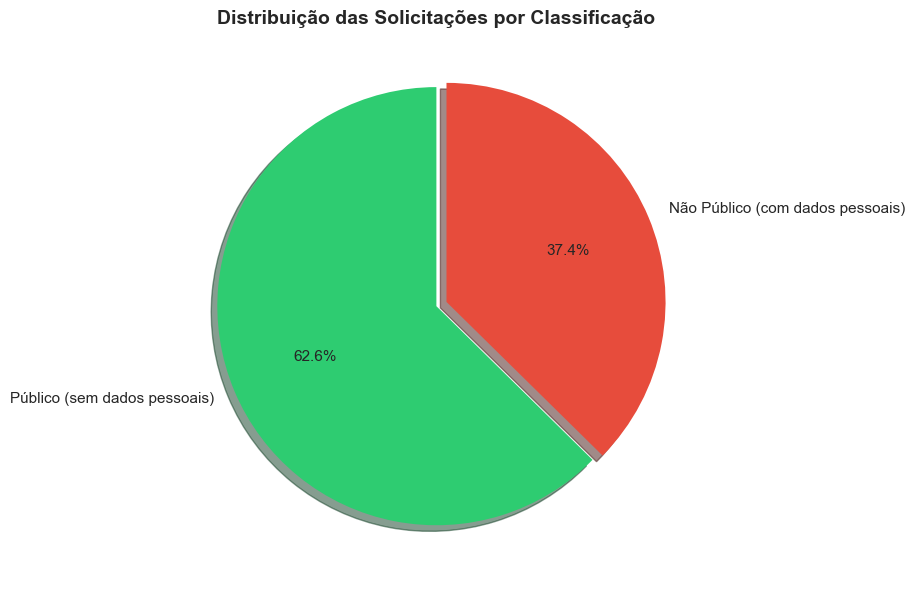

In [17]:
# Gráfico de pizza - Distribuição das classificações
valores = df['classificacao_final'].value_counts()
labels = ['Público (sem dados pessoais)', 'Não Público (com dados pessoais)']
cores = ['#2ecc71', '#e74c3c']

plt.figure(figsize=(8, 6))
plt.pie(valores, labels=labels, colors=cores, autopct='%1.1f%%', startangle=90,
        explode=(0, 0.05), shadow=True, textprops={'fontsize': 11})
plt.title('Distribuição das Solicitações por Classificação', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## `Feature Engineering`

Etapa de criação de features para experimentação com modelos de ***Machine Learning***.

Aqui o objetivo é criar features (**variáveis**) que ajudem o ***modelo de ML*** a aprender padrões para classificar os textos. Como estamos trabalhando com texto, criei dois tipos de features:

- **Features numéricas** -- estatísticas do texto
-  **Features de texto vetorizado** -- transformar texto em números (TF-IDF)

> Features Numéricas:

In [18]:
# Criar features numéricas baseadas no texto
df['qtd_digitos'] = df['Texto Mascarado'].apply(lambda x: sum(c.isdigit() for c in str(x)))
df['qtd_pontuacao'] = df['Texto Mascarado'].apply(lambda x: sum(c in '.,;:!?@-/' for c in str(x)))
df['razao_digitos'] = df['qtd_digitos'] / df['tamanho_texto']

# Verificar as novas features
print("=== FEATURES NUMÉRICAS ===")
print(df[['ID', 'tamanho_texto', 'qtd_palavras', 'qtd_digitos', 'qtd_pontuacao', 'razao_digitos']].head(10))

=== FEATURES NUMÉRICAS ===
   ID  tamanho_texto  qtd_palavras  qtd_digitos  qtd_pontuacao  razao_digitos
0   1            364            63            0              6       0.000000
1   2            262            43            0              6       0.000000
2   3            741           136            0              8       0.000000
3   4            162            22           19              8       0.117284
4   5             88            14            0              1       0.000000
5   6            217            31           19              8       0.087558
6   7           1111           171           67             39       0.060306
7   8            537            82           12             10       0.022346
8   9             85            15            8              3       0.094118
9  10            558            84           41             23       0.073477


> Vetorização do Texto (TF-IDF)

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Criar vetorizador TF-IDF
tfidf = TfidfVectorizer(max_features=100, ngram_range=(1, 2), stop_words=None)

# Aplicar ao texto
tfidf_matrix = tfidf.fit_transform(df['Texto Mascarado'])

# Converter para DataFrame
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf.get_feature_names_out())

print(f"=== TF-IDF ===")
print(f"Shape: {tfidf_df.shape}")
print(f"\nPrimeiras 10 features:")
print(tfidf_df.columns[:10].tolist())

=== TF-IDF ===
Shape: (99, 100)

Primeiras 10 features:
['05', '12', '15', '2021', '2023', '2025', 'acesso', 'acesso ao', 'ao', 'ao processo']


> Combinação de Features Numéricas + TF-IDF

In [20]:
# Features numéricas
features_numericas = df[['tamanho_texto', 'qtd_palavras', 'qtd_digitos', 'qtd_pontuacao', 'razao_digitos']]

# Resetar índices
features_numericas = features_numericas.reset_index(drop=True)
tfidf_df = tfidf_df.reset_index(drop=True)

# Combinar features
X = pd.concat([features_numericas, tfidf_df], axis=1)
y = df['classificacao_final'].reset_index(drop=True)

print("=== DATASET PARA MODELAGEM ===")
print(f"Features (X): {X.shape}")
print(f"Target (y): {y.shape}")
print(f"\nDistribuição do target:")
print(y.value_counts())

=== DATASET PARA MODELAGEM ===
Features (X): (99, 105)
Target (y): (99,)

Distribuição do target:
classificacao_final
0    62
1    37
Name: count, dtype: int64


## `Teste Final com algoritmo Random Forest`

#### - **Divisão Treino/teste e Treinamento do Modelo**

In [21]:
# Dividir em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Treino: {X_train.shape[0]} amostras")
print(f"Teste: {X_test.shape[0]} amostras")

# Treinar modelo Random Forest
modelo = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
modelo.fit(X_train, y_train)

# Predições
y_pred = modelo.predict(X_test)

# Avaliação
print("\n=== RESULTADOS DO MODELO ===")
print(f"Acurácia: {accuracy_score(y_test, y_pred):.2%}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Público', 'Não Público']))

Treino: 79 amostras
Teste: 20 amostras

=== RESULTADOS DO MODELO ===
Acurácia: 60.00%

Classification Report:
              precision    recall  f1-score   support

     Público       0.67      0.77      0.71        13
 Não Público       0.40      0.29      0.33         7

    accuracy                           0.60        20
   macro avg       0.53      0.53      0.52        20
weighted avg       0.57      0.60      0.58        20



## `Conclusão da Análise Exploratória`

### Resultados:
- **Abordagem híbrida (Regex + NLP)** apresentou os melhores resultados
- Detectamos **37 textos com dados pessoais** (37.4%)
- O modelo de ML teve desempenho limitado devido ao tamanho do dataset (99 registros)

### Próximos passos:
- Notebook 02: Modelo final consolidado para submissão
- Notebook 03: Experimentos com outros algoritmos de ML